In [38]:
from pytorch_wavelets import DWT1DForward, DWT1DInverse  # or simply DWT1D, IDWT1D
import torch
import torch.nn as nn
from einops import rearrange, repeat
from torch.nn import init
from soh_train import PreNorm, FeedForward, Attention, Transformer, Depth_Pointwise_Conv1d
input = 2
numf =24

In [39]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io
from datetime import datetime
import sys
import time

import math

import plotly
from importlib import reload
import plotly.graph_objects as go
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from tqdm import tqdm

dir_path = "C:/Users/13932/Desktop/MVIP-Trans/data/calce/"
data_path="C:/Users/13932/Desktop/MVIP-Trans/"
IS_TRAINING=True
device=torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
sys.path.append(data_path)



import matplotlib.pyplot as plt


import glob
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

def to_padded_numpy(l, shape):
        padded_array = np.zeros(shape)
        for i,j in enumerate(l): 
            padded_array[i][0:len(j)] = j
        return padded_array


Battery_list1 = ['CS2_37']
Battery_list2 = ['CS2_37']
dir_path = "C:/Users/13932/Desktop/MVIP-Trans/data/calce/"
Battery1 = {}
Battery2 = {}
voltagee=[]
currentt=[]
voltageee=[]
currenttt=[]
current1=[]
voltage1=[]
current2=[]
voltage2=[]
train_y=[]
test_y=[]
max_step=0
count = 0
for name in Battery_list1:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    # print(path)
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    # print(idx)
    path_sorted = np.array(path)[idx]
    print(path_sorted)
    
    
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []

    for p in path_sorted:
        
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                voltagee.append(list(d_v))
                currentt.append(list(d_c))
                d_c = np.array(list(d_c))[1:]
                max_step = max(max_step, len(currentt[-1]))
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    
    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    idx = drop_outlier(discharge_capacities, count, 40)
    for i in idx:
        current1.append(currentt[i])
        voltage1.append(voltagee[i])


    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery1[name] = df_result

for name in Battery_list1:
    train_y.append(Battery1[name]['capacity'])

current1 = to_padded_numpy(current1, [len(current1), max_step])
voltage1 = to_padded_numpy(voltage1, [len(voltage1), max_step])
current1=current1[:,:,np.newaxis]
voltage1=voltage1[:,:,np.newaxis]
train_x=np.concatenate((current1,voltage1),axis=2)
train_y=[i for item in train_y for i in item]
train_y=np.array(train_y)
train_y=train_y.reshape(-1,1)
train_x=train_x[:,:374,:]
print(train_x.shape)
print(train_y.shape)

max_step=0
count = 0
for name in Battery_list2:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []

    for p in path_sorted:
        
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                voltageee.append(list(d_v))
                currenttt.append(list(d_c))
                d_c = np.array(list(d_c))[1:]
                max_step = max(max_step, len(currenttt[-1]))
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    
    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    idx = drop_outlier(discharge_capacities, count, 40)
    for i in idx:
        current2.append(currenttt[i])
        voltage2.append(voltageee[i])


    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery2[name] = df_result

for name in Battery_list2:
    test_y.append(Battery2[name]['capacity'])

current2 = to_padded_numpy(current2, [len(current2), max_step])
voltage2 = to_padded_numpy(voltage2, [len(voltage2), max_step])
current2=current2[:,:,np.newaxis]
voltage2=voltage2[:,:,np.newaxis]
# print('voltage:', voltage2[0])
# print('current:', current2[0])
test_x=np.concatenate((current2,voltage2),axis=2)
test_y=[i for item in test_y for i in item]
test_y=np.array(test_y)
test_y=test_y.reshape(-1,1)
print(test_x.shape)
print(test_y.shape)


for j in range(train_x.shape[0]):
    for i in range(train_x.shape[2]):
        train_x[j,:,i]=(train_x[j,:,i]-np.mean(train_x[j,:,i]))/np.std(train_x[j,:,i])

for j in range(test_x.shape[0]):
    for i in range(test_x.shape[2]):
        test_x[j,:,i]=(test_x[j,:,i]-np.mean(test_x[j,:,i]))/np.std(test_x[j,:,i])
train_x=torch.tensor(train_x)
train_y=torch.tensor(train_y)
test_x=torch.tensor(test_x)
test_y=torch.tensor(test_y)
train_x=train_x.float()
train_y=train_y.float()
test_x=test_x.float()
test_y=test_y.float()
train_x=train_x.transpose(1,2)
test_x=test_x.transpose(1,2)
train_data = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
test_data = TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_data)

Load Dataset CS2_37 ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_10_04_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_10_05_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_10_14_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_10_21_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_10_28_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_11_01_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_11_08_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_11_15_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_11_22_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_11_24_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_12_06_10.xlsx ...
Load C:/Users/13932/Desktop/MVIP-Trans/data/calce/CS2_37\CS2_37_12_13_10.x

In [40]:
class SpatialGroupEnhance(nn.Module):

    def __init__(self, groups):
        super().__init__()
        self.groups=groups
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.weight=nn.Parameter(torch.zeros(1,groups,1))
        self.bias=nn.Parameter(torch.zeros(1,groups,1))
        self.sig=nn.Sigmoid()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, h=x.shape
        x=x.view(b*self.groups,-1,h) #bs*g,dim//g,h,w
        xn=x*self.avg_pool(x) #bs*g,dim//g,h,w
        xn=xn.sum(dim=1,keepdim=True) #bs*g,1,h,w
        t=xn.view(b*self.groups,-1) #bs*g,h*w

        t=t-t.mean(dim=1,keepdim=True) #bs*g,h*w
        std=t.std(dim=1,keepdim=True)+1e-5
        t=t/std #bs*g,h*w
        t=t.view(b,self.groups,h) #bs,g,h*w
        
        t=t*self.weight+self.bias #bs,g,h*w
        t=t.view(b*self.groups,1,h) #bs*g,1,h*w
        x=x*self.sig(t)
        x=x.view(b,c,h)

        return x 

class SConv_1D(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch, kernel, pad):
        super(SConv_1D, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel, padding=pad),
            nn.GroupNorm(2, out_ch),
            #nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)
        return x


class Net(nn.Module):
    def __init__(self,num_classes, dim, depth, mlp_dim, heads, pool='cls', channels=1,
                 dim_head=64, dropout=0., emb_dropout=0.):
        super(Net, self).__init__()
        self.DWT0 = DWT1DForward(J=1, wave='db16').cuda()
        self.Conv1 = SConv_1D(4, 32, 3, 0)
        self.Conv11 = nn.Conv1d(32, 32, 3, groups=32)
        self.avg = nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
        self.DWT1 = DWT1DForward(J=1, wave='db16').cuda()
        self.dropout1 = nn.Dropout(p=0.1)
        self.sge1 = SpatialGroupEnhance(groups=4)
        self.Conv2 = nn.Conv1d(64, 112, 3, groups=4)
        """Transformer"""
        num_patches = 184

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        # self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = x.to(torch.float32)
        DMT_yl,DMT_yh = self.DWT0(x)
        x = torch.cat([DMT_yl,DMT_yh[0]], dim=1) # 32, 4, 202
        # print(x.shape)
        x = self.Conv1(x)  # [14, 32, 343]
        x = self.Conv11(x)  # [14, 32, 341]
        # output=self.avg(output)
        DMT_yl, DMT_yh = self.DWT1(x)
        x = torch.cat([DMT_yl, DMT_yh[0]], dim=1)  # [14, 64, 114]
        # print(x.shape)
        # plt.subplots(1, figsize=(18, 9))
        # a = x[0].reshape(114, 64).cpu().detach().numpy()
        # a = a[0:100]
        # sns.heatmap(a.reshape(64, 100))
        # plt.show()
        x = self.Conv2(x) # [20, 184, 184]
        # print(x.shape)
        x = rearrange(x, 'b r p -> b p r')
        # print('input size: ', x.shape)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

2024-08-24-20-17-31_wavenet_rul_nasa_
train epoch[9/10] loss:0.003 mse:0.006 mae:0.072: 100%|██████████| 31/31 [00:01<00:00, 16.22it/s]
train epoch[10/10] loss:0.001 mse:0.001 mae:0.022: 100%|██████████| 31/31 [00:02<00:00, 14.33it/s]
100%|██████████| 972/972 [00:10<00:00, 88.39it/s] 
CS2_38 test mse: 0.002475927583873272
CS2_38 test mae: 0.039882440119981766
CS2_38 test rmse: 0.04975869355070802
Predicated:
1.0055363178253174
1.0055277347564697
1.005497694015503
1.0141618251800537
1.0141466856002808
1.0145472288131714
1.0076913833618164
1.0078908205032349
1.0042234659194946
1.004112958908081
1.0079411268234253
1.0078392028808594
1.0078235864639282
1.0078562498092651
1.0078809261322021
1.0079399347305298
1.007933497428894
1.0079421997070312
1.0079691410064697
1.0079867839813232
1.0043202638626099
1.0043044090270996
1.0042990446090698
1.0042777061462402
1.004262089729309
1.013378620147705
1.0110821723937988
1.0109740495681763
1.0081576108932495
1.008101463317871
1.0111280679702759
1.013

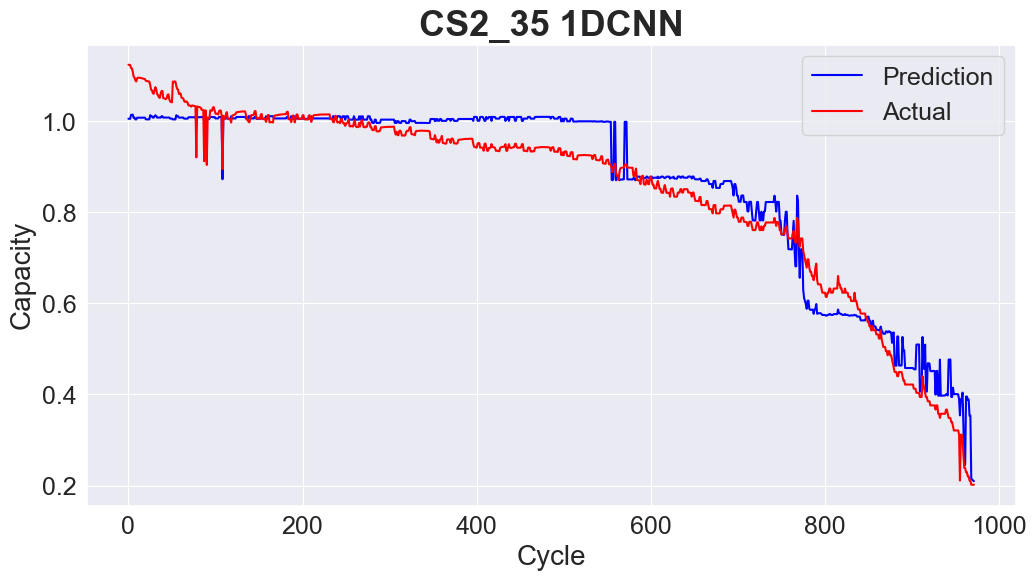

In [45]:
if IS_TRAINING:
    EXPERIMENT = "wavenet_rul_nasa_"

    experiment_name = time.strftime("%Y-%m-%d-%H-%M-%S") + '_' + EXPERIMENT
    print(experiment_name)

    net = Net(dim = 112,
        num_classes = 1,
        depth = 12,
        mlp_dim = 3,
        heads = 8).to(device)
    net.to(device)
    loss_function = torch.nn.SmoothL1Loss()
    criteria1 = nn.MSELoss()
    criteria2 = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    
if IS_TRAINING:
    epochs = 10
    train_predictions =[] 
    best_acc = 0.0
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()

        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, train_data in enumerate(train_bar):
            battery, rul = train_data
            # print(battery.shape) # [32, 2, 374]
            optimizer.zero_grad()
            outputs = net(battery.to(device))
            loss = loss_function(outputs, rul.to(device))
            mse=criteria1(outputs, rul.to(device))
            mae=criteria2(outputs, rul.to(device))
            loss.backward()
            optimizer.step()

            if epoch+1==epochs:
                train_predictions.extend(outputs.data.tolist())

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f} mse:{:.3f} mae:{:.3f}".format(epoch + 1,
                                                                     epochs,loss,mse,mae)

    

save_path = data_path + 'result/calce_model/%s.pth' % experiment_name
if IS_TRAINING:
    torch.save(net.state_dict(), save_path)
if not IS_TRAINING:
    model = Net(dim = 184,
        num_classes = 1,
        depth = 12,
        mlp_dim = 3,
        heads = 8).to(device)
    model.load_state_dict(torch.load(save_path))
    
net.eval()
mse0=[]
mae0=[]
test_predictions =[] 
criteria1 = nn.MSELoss()
criteria2 = nn.L1Loss()
with torch.no_grad():
    test_bar = tqdm(test_loader, file=sys.stdout)
    for test_data in test_bar:
        battery, rul = test_data
        outputs = net(battery.to(device))
        mse=criteria1(outputs, rul.to(device))
        mae=criteria2(outputs, rul.to(device))
        mse0.append(mse)
        mae0.append(mae)
        test_predictions.extend(outputs.data.tolist())

    print("CS2_38 test mse: {}".format(sum(mse0[:])/996))
    print("CS2_38 test mae: {}".format(sum(mae0[:])/996))
    print("CS2_38 test rmse: {}".format(math.sqrt(sum(mse0[:])/996)))
 

train_predictions=np.squeeze(np.array(train_predictions))
test_predictions=np.squeeze(np.array(test_predictions))
test_y=np.squeeze(np.array(test_y))

# print(list(test_y))
# print('Real:')
# for j in range(len(list(test_y))):
#     print(test_y[j])
print('Predicated:')
for j in range(len(list(test_predictions))):
    print(test_predictions[:][j])
color_list = ['b', 'r', 'g']
fig, ax = plt.subplots(1, figsize=(12, 6))
c = 0
color = color_list[c]
x=np.arange(len(list(test_y)))
ax.plot(x, test_predictions[:], color, label='Prediction')
c += 1
color = color_list[c]
ax.plot(x, test_y[:], color, label='Actual')
plt.xlabel('Cycle',fontsize=20)
plt.ylabel( 'Capacity',fontsize=20)
plt.title('CS2_35 1DCNN',fontsize=26,weight='bold')
plt.legend(loc="upper right",prop = {'size':18})
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2)####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2)###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2)####设置上部坐标轴的粗细
plt.tick_params(labelsize=18)#刻度大小
plt.savefig("C:/Users/13932/Desktop/MVIP-Trans/result/calce1DCNN.jpg",dpi=300)
plt.show()